In [2]:
print('Importing...')

%matplotlib inline

import glob
import os
import numpy as np
import time as systime
import re 
import textgrid as tg
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from bokeh.plotting import show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from ipyparallel import Client
import _pickle as pickle

import sys

np.random.seed(6)

print('success')

Importing...
success


- Manually specify a top string, a bottom string, and an MFCC output.

In [3]:
top_string = [0,1,0]
top_strings = [top_string]
bot_string = [0,2,1,0]
bot_string_states = [0,0,1,2, 6,7,7,8, 3,3,4,5, 0,1,2,2]
print('success')

success


Let's define the HMM/GMM parameters

In [4]:
# transition = [[.5, .5, 0],
#              [0, .5, .5],
#              [.75, 0, .25]]

components = []
# Distribution over components for each bottom PLU state
components.extend([[.7,.3],
             [.9,.1],
             [.3,.7]])
components.extend([[.3,.7],
             [.5,.5],
             [.8,.2]])
components.extend([[.4,.6],
             [.2,.8],
             [.9,.1]])

# We need a set of parameters for each component
# for each HMM state for each bottom PLU
# So in this case, we need 2 * 3 * 3 = 18 sets of parameters

component_parameters = [
        [
            [[-2,-5], [[1,0],[0,1]]], # bottom PLU 0, HMM state 0, component 0
            [[-2.1,-5.1], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 0, component 1
        ],
        [
             [[-2.2,-5.2], [[1,0],[0,1]]], # bottom PLU 0, HMM state 1, component 0
             [[-2.3,-5.3], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 1, component 1
        ],
        [
            [[-2.4,-5.4], [[1,0],[0,1]]], # bottom PLU 0, HMM state 2, component 0
            [[-2.5,-5.5], [[1,0],[0,1]]]  # bottom PLU 0, HMM state 2, component 1
        ],
    
    
        [
            [[0.0,3.0], [[1,0],[0,1]]], # bottom PLU 1, HMM state 0, component 0
            [[0.1,3.1], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 0, component 1
        ],
        [
             [[0.2,3.2], [[1,0],[0,1]]], # bottom PLU 1, HMM state 1, component 0
             [[0.3,3.3], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 1, component 1
        ],
        [
            [[0.4,3.4], [[1,0],[0,1]]], # bottom PLU 1, HMM state 2, component 0
            [[0.5,3.5], [[1,0],[0,1]]]  # bottom PLU 1, HMM state 2, component 1
        ],
    
          
        [
            [[5.0,0.0], [[1,0],[0,1]]], # bottom PLU 2, HMM state 0, component 0
            [[5.1,0.1], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 0, component 1
        ],
        [
             [[5.2,0.2], [[1,0],[0,1]]], # bottom PLU 2, HMM state 1, component 0
             [[5.3,0.3], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 1, component 1
        ],
        [
            [[5.4,0.4], [[1,0],[0,1]]], # bottom PLU 2, HMM state 2, component 0
            [[5.5,0.5], [[1,0],[0,1]]]  # bottom PLU 2, HMM state 2, component 1
        ]
    

]

component_parameters_flat = []
_ = [component_parameters_flat.extend(x) for x in component_parameters]

# densities = [ [multivariate_normal(mean=comp[0], cov=comp[1]) for comp in comps] for comps in component_parameters]

# densities_flat = []

# [densities_flat.extend(x) for x in densities]

# print(densities_flat)

print(component_parameters_flat)


print('success')


[[[-2, -5], [[1, 0], [0, 1]]], [[-2.1, -5.1], [[1, 0], [0, 1]]], [[-2.2, -5.2], [[1, 0], [0, 1]]], [[-2.3, -5.3], [[1, 0], [0, 1]]], [[-2.4, -5.4], [[1, 0], [0, 1]]], [[-2.5, -5.5], [[1, 0], [0, 1]]], [[0.0, 3.0], [[1, 0], [0, 1]]], [[0.1, 3.1], [[1, 0], [0, 1]]], [[0.2, 3.2], [[1, 0], [0, 1]]], [[0.3, 3.3], [[1, 0], [0, 1]]], [[0.4, 3.4], [[1, 0], [0, 1]]], [[0.5, 3.5], [[1, 0], [0, 1]]], [[5.0, 0.0], [[1, 0], [0, 1]]], [[5.1, 0.1], [[1, 0], [0, 1]]], [[5.2, 0.2], [[1, 0], [0, 1]]], [[5.3, 0.3], [[1, 0], [0, 1]]], [[5.4, 0.4], [[1, 0], [0, 1]]], [[5.5, 0.5], [[1, 0], [0, 1]]]]
success


In [5]:
print('running...')

def sample_gmm(bottom_hmm_states):
    
    mfccs = []
    
    component_choices = []
    
    for state in bottom_hmm_states:
        vec = None
        gmm_component_choice = np.random.choice(2,p=components[state])
        component_choices.append(gmm_component_choice)
        params = component_parameters[state][gmm_component_choice]
        vec = np.random.multivariate_normal(mean=params[0], cov=params[1])
        mfccs.append(vec)
            
    return np.array(mfccs), component_choices

all_data = []


mfccs, component_choices = sample_gmm(bot_string_states)

all_data.append(mfccs)

print('success')

for i in range(mfccs.shape[0]):
    print(mfccs[i,:], ", drawn from Gaussian with mean ", component_parameters_flat[bot_string_states[i]*2+component_choices[i]])
        
print('bottom string: \n', bot_string_states)

print('mfccs: \n', mfccs)


# for frame in mfccs:
#     print([np.log(mv.pdf(frame)) for mv in densities_flat])
        

running...
success
[-1.09508274 -5.62562604] , drawn from Gaussian with mean  [[-2.1, -5.1], [[1, 0], [0, 1]]]
[-1.78217921 -5.8990918 ] , drawn from Gaussian with mean  [[-2, -5], [[1, 0], [0, 1]]]
[-3.99564343 -6.08578287] , drawn from Gaussian with mean  [[-2.2, -5.2], [[1, 0], [0, 1]]]
[-0.86070892 -5.9298936 ] , drawn from Gaussian with mean  [[-2.5, -5.5], [[1, 0], [0, 1]]]
[ 6.94913793  1.10320135] , drawn from Gaussian with mean  [[5.1, 0.1], [[1, 0], [0, 1]]]
[ 4.96411839  1.53773784] , drawn from Gaussian with mean  [[5.3, 0.3], [[1, 0], [0, 1]]]
[ 6.17722778  0.93472317] , drawn from Gaussian with mean  [[5.3, 0.3], [[1, 0], [0, 1]]]
[ 5.75480861  2.21259031] , drawn from Gaussian with mean  [[5.4, 0.4], [[1, 0], [0, 1]]]
[-0.10678997  3.50517128] , drawn from Gaussian with mean  [[0.0, 3.0], [[1, 0], [0, 1]]]
[ 0.82465384  1.82356852] , drawn from Gaussian with mean  [[0.0, 3.0], [[1, 0], [0, 1]]]
[ 0.57473356  3.43652337] , drawn from Gaussian with mean  [[0.3, 3.3], [[1, 

In [6]:
def collect_data_stats(data):
    """Job to collect the statistics."""
    # We  re-import this module here because this code will run
    # remotely.
    
    stats_0 = data.shape[0]
    stats_1 = data.sum(axis=0)
    stats_2 = (data**2).sum(axis=0)
    retval = (
        stats_0,
        stats_1,
        stats_2
    )
    return retval

data_stats = list(map(collect_data_stats, all_data))

print('success')

success


In [7]:

def accumulate_stats(data_stats):
    n_frames = data_stats[0][0]
    mean = data_stats[0][1]
    var = data_stats[0][2]
    for stats_0, stats_1, stats_2 in data_stats[1:]:
        n_frames += stats_0
        mean += stats_1
        var += stats_2
    mean /= n_frames
    var = (var / n_frames) - mean**2

    data_stats = {
        'count': n_frames,
        'mean': mean,
        'var': var
    }
    return data_stats

final_data_stats = accumulate_stats(data_stats)

print('success')

success


In [8]:
print(all_data)



[array([[-1.09508274, -5.62562604],
       [-1.78217921, -5.8990918 ],
       [-3.99564343, -6.08578287],
       [-0.86070892, -5.9298936 ],
       [ 6.94913793,  1.10320135],
       [ 4.96411839,  1.53773784],
       [ 6.17722778,  0.93472317],
       [ 5.75480861,  2.21259031],
       [-0.10678997,  3.50517128],
       [ 0.82465384,  1.82356852],
       [ 0.57473356,  3.43652337],
       [-0.18661296,  1.91814673],
       [-2.75666684, -3.53288682],
       [-4.42714455, -6.13440747],
       [-2.6840664 , -6.25624874],
       [-3.28015214, -4.54439041]])]


In [9]:

print("Running...")

import subprocess
import amdtk
num_tops = 4

print("Finished imports in ipython notebook.")

print(len(all_data))
print(len(top_strings))
all_data_and_tops = list(zip(all_data, top_strings))
#print(all_data_and_tops[0])

print("starting engines")
subprocess.Popen(['ipcluster', 'start',' --profile', 'default',' -n', '4', '--daemonize'])
subprocess.Popen(['sleep', '10']).communicate()


rc = Client(profile='default')
dview = rc[:]
print('Connected to', len(dview), 'jobs.')


elbo = []
time = []
def callback(args):
    elbo.append(args['lower_bound'])
    time.append(args['time'])
    print('elbo=' + str(elbo[-1]), 'time=' + str(time[-1]))
 

print("Creating phone loop model...")
conc = 0.1

n_units=3
n_states=3
n_comp_per_state=2


model = amdtk.PhoneLoopNoisyChannel.create(
    n_units=n_units,  # number of acoustic units
    n_states=n_states,   # number of states per unit
    n_comp_per_state=n_comp_per_state,   # number of Gaussians per emission
    n_top_units=num_tops, # size of top PLU alphabet
    mean=np.zeros_like(final_data_stats['mean']), 
    var=np.ones_like(final_data_stats['var']),
    max_slip_factor=.05
    #concentration=conc
)


print("Creating VB optimizer...")   
optimizer = amdtk.ToyNoisyChannelOptimizer(
    dview, 
    final_data_stats, 
    args= {'epochs': 4,
     'batch_size': 4,
     'lrate': 1,
     'pkl_path': "example_test",
     'log_dir': 'logs'},
    model=model,
    dir_path='dir'
)

print("Running VB optimization...")
begin = systime.time()
print("running with toy data")
print('len(all_data_and_tops[0])')
print(len(all_data_and_tops[0]))
optimizer.run(all_data_and_tops, callback)
end = systime.time()
print("VB optimization took ",end-begin," seconds.")

# fig1 = figure(
#     x_axis_label='time (s)', 
#     y_axis_label='ELBO',
#     width=400, 
#     height=400
# )
# x = np.arange(0, len(elbo), 1)
# fig1.line(x, elbo)
#show(fig1)

print("\nDECODING\n")

date_string = systime.strftime("textgrids_%Y-%m-%d_%H:%M")

# Need to change this according to 
samples_per_sec = 100

all_data_and_tops = list(zip(all_data, top_strings))

for data, tops in all_data_and_tops:

    # Normalize the data
    data_mean = np.mean(data)
    data_var = np.var(data)
    data = (data-data_mean)/np.sqrt(data_var)

    #result = model.decode(data, tops, state_path=False)
    #result_path = model.decode(data, tops, state_path=True)
    (result_intervals, edit_path, hmm_state_path) = model.decode(data, tops, phone_intervals=True, edit_ops=True, hmm_states=True, plus=False)

    print("---")
    print("Phone sequence:")
    print(result_intervals)
    print(edit_path)
    print(hmm_state_path)
    

Running...
INSIDE INIT
SUCCESSFUL IMPORT IN INIT
Finished imports in ipython notebook.
1
1
starting engines


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyparallel/client/client.py:442: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@192.168.0.214')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Connected to 4 jobs.
Creating phone loop model...
[-2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45]
[-2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45]
[-2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45]
[-2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45]
Creating VB optimizer...
importing numpy on engine(s)
importing read_htk from amdtk on engine(s)
importing _pickle on engine(s)
importing os on engine(s)
Running VB optimization...
running with toy data
len(all_data_and_tops[0])
2
[[  2.45217859e+00   1.76304390e-02]
 [  2.23013831e+00   1.44744254e-02]
 [  2.89671802e+00   1.44814475e-02]
 [  5.11543175e-01   5.47762119e-02]
 [  4.55160874e-03   1.51288094e-01]
 [  1.18783153e-01   8.21933774e-02]
 [  4.06798490e-03   1.01847769e+00]
 [  5.14506734e+00   8.75095209e-02]
 [  4.28773131e-01   7.67347475e-01]]
[[  2.11718183e+01   7.04628542e+01  -6.31987995e+00  -1.28951358e+01
    2.45217859e+00   2.45217859e+00   2.45217859e+00   2.45217859e+00]
 [  1.04658270e-01   3.97240174e-01  -6.26739535e-03  -6.37444682e-0

[[  1.67277879e+00   9.23387335e-01]
 [  2.62133731e+00   2.91484607e-03]
 [  2.88126568e+00   4.40080299e-06]
 [  4.62209343e-21   4.62209343e-21]
 [  2.15404998e-21   2.15404998e-21]
 [  1.36128177e-21   1.36128177e-21]
 [  1.00069452e+00   2.18139921e+00]
 [  1.92555547e+00   1.49233671e-03]
 [  1.99497284e-02   2.76922037e+00]]
[[  5.14587651e+00   3.89955111e+01  -2.50302153e+00  -7.05153163e+00
    1.67277879e+00   1.67277879e+00   1.67277879e+00   1.67277879e+00]
 [  7.15184786e-02   4.14484481e+00  -8.30805490e-02   1.91019680e+00
    9.23387335e-01   9.23387335e-01   9.23387335e-01   9.23387335e-01]
 [  2.43041483e+01   8.34391145e+01  -7.46837935e+00  -1.45441519e+01
    2.62133731e+00   2.62133731e+00   2.62133731e+00   2.62133731e+00]
 [  1.54420825e-04   1.08899701e-02  -5.50440240e-04   5.57603848e-03
    2.91484607e-03   2.91484607e-03   2.91484607e-03   2.91484607e-03]
 [  3.60672897e+01   9.17871656e+01  -1.00621990e+01  -1.61111151e+01
    2.88126568e+00   2.88126568e

In [10]:
learned_components = model.components
learned_posteriors = [comp.posterior for comp in learned_components]
dimensionality = all_data[0].shape[1]
learned_natural_params = [post.natural_params.reshape((-1,dimensionality)) for post in learned_posteriors]
learned_means = [ n[1]/n[2] for n in learned_natural_params ]
learned_vars = [ (n[0]-((n[1]**2)/n[2]))/(n[3]+1) for n in learned_natural_params ]

learned_means = learned_means * np.sqrt(final_data_stats['var']) + final_data_stats['mean']
learned_vars = learned_vars * np.sqrt(final_data_stats['var'])

print(learned_means)
print(learned_vars)


[[ -3.14222158 -11.97329384]
 [  0.09768703   2.13827321]
 [ -7.22556626 -17.32799971]
 [  0.25236145  -1.69943626]
 [ -9.14848687 -17.85166197]
 [  0.25434856  -1.72100994]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [ -1.30610667 -13.23399276]
 [ 15.46392206   1.53205441]
 [ 13.28355177   2.88726396]
 [  0.25708464  -1.70714129]
 [  0.30734611  -1.57414912]
 [  1.39092062   6.53398807]]
[[  4.74189036  23.69133276]
 [  2.56559973   5.64639472]
 [  8.55607339  22.72576072]
 [  3.62193324   3.90137745]
 [  8.90225079  21.42299404]
 [  3.62692561   3.88598895]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  2.86519725  25.39651392]
 [ 25.40403903   2.94257469]
 [ 23.31437508   4.94204004]
 [  3.6254515    3.90158537]
 [  3.6130113

18
36
18
36
[[ -3.14222158 -11.97329384]
 [  0.09768703   2.13827321]
 [ -7.22556626 -17.32799971]
 [  0.25236145  -1.69943626]
 [ -9.14848687 -17.85166197]
 [  0.25434856  -1.72100994]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [  0.25435206  -1.72104157]
 [ -1.30610667 -13.23399276]
 [ 15.46392206   1.53205441]
 [ 13.28355177   2.88726396]
 [  0.25708464  -1.70714129]
 [  0.30734611  -1.57414912]
 [  1.39092062   6.53398807]]
[[  4.74189036  23.69133276]
 [  2.56559973   5.64639472]
 [  8.55607339  22.72576072]
 [  3.62193324   3.90137745]
 [  8.90225079  21.42299404]
 [  3.62692561   3.88598895]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  3.62693244   3.88596462]
 [  2.86519725  25.39651392]
 [ 25.40403903   2.94257469]
 [ 23.31437508   4.94204004]
 [  3.6254515    3.90158537]
 

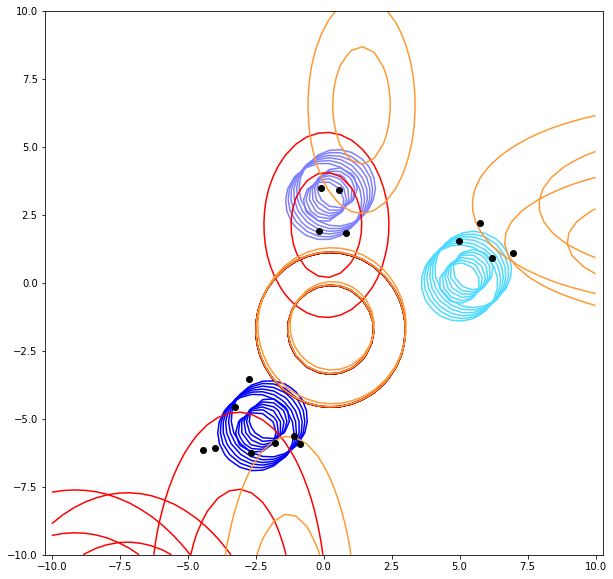

In [12]:
def gaussian_2d(x, y, dist):
    return dist.pdf([x,y])

gaussian_2d_v = np.vectorize(gaussian_2d)


def plot_gauss_2d(mean, cov, xlim=(-2.0, 2.0), ylim=(-2.0, 2.0), colors='k'):
    mv = multivariate_normal(mean=mean, cov=cov)
    x = np.linspace(*xlim)
    y = np.linspace(*ylim)
    X, Y = np.meshgrid(x, y)
    Z = gaussian_2d_v(X, Y, mv)
    CS = plt.contour(X, Y, Z, 2, colors=colors)
    #fmt = {CS.levels[0]: '95%', CS.levels[1]: '99%'}
    #plt.clabel(CS, fmt=fmt)
    
plt.figure(figsize=(10, 10))
plt.axis('equal')
xlim = (-10, 10)
ylim = (-10, 10)


plt.axis('equal')
xlim = (-10, 10)
ylim = (-10, 10)
# plot_gauss_2d(mean=[0,1], cov=[[1,0.5],[0.5,1]])
# plot_gauss_2d(mean=[1,0], cov=[[1,-0.5],[-0.5,1]])

component_parameters

def list_repeat(given_list, repeat_factor):
    return_list = []
    for item in given_list:
        return_list.extend([item]*repeat_factor)
    return return_list


colors_given_list = ['#0000ff', '#8080ff', '#4ddbff', '#007a99', '#00cc00', '#008000']
colors_learned_list = ['#ff0000', '#990000', '#ff9933', '#b35900', '#ffcc00', '#ff6633']


colors_given = list_repeat(colors_given_list, n_states*n_comp_per_state)
colors_learned = list_repeat(colors_learned_list, n_states*n_comp_per_state)

print(len(component_parameters_flat))
print(len(colors_given))
print(len(learned_means))
print(len(colors_learned))

print(learned_means)
print(learned_vars)



# Plot gaussians used to generate data
_ = [ plot_gauss_2d(mean=comp[0], cov=comp[1], xlim=xlim, ylim=ylim, colors=color) for comp, color in zip(component_parameters_flat, colors_given)]

# Plot gaussians learned from data
_ = [ plot_gauss_2d(mean=mean, cov=[[var[0],0],[0,var[1]]], xlim=xlim, ylim=ylim, colors=color) for mean, var, color in zip(learned_means, learned_vars, colors_learned)]

# Plot data
plt.plot(mfccs[:,0], mfccs[:,1], 'ko')
